In [1]:
# File handling
import os
import pickle

# General functions
import numpy as np
import pandas as pd

# Sci-kit learn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, PredefinedSplit
from sklearn.neural_network import MLPClassifier
import sklearn.pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
# import sklearn.linear_model
# import sklearn.model_selection as skms
# import sklearn.feature_selection
# from sklearn.utils import shuffle
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Import our custom functions
from load_data import load_data 

Load training and validation data:

x data is an array of N*784 pixels (N = 2102 for tr, 600 for va)

y is a dataframe of index, class_name and class_id

In [2]:
x_tr, y_tr_df = load_data('x_train.csv', 'y_train.csv')
x_va, y_va_df = load_data('x_valid.csv', 'y_valid.csv')
x_te = load_data('x_test.csv', 'y_valid.csv')[0]


for label, arr in [('train', x_tr), ('valid', x_va)]:
    print("Contents of %s_x.csv: arr of shape %s" % (
        label, str(arr.shape)))

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


Plot a random image from the validation data for each category

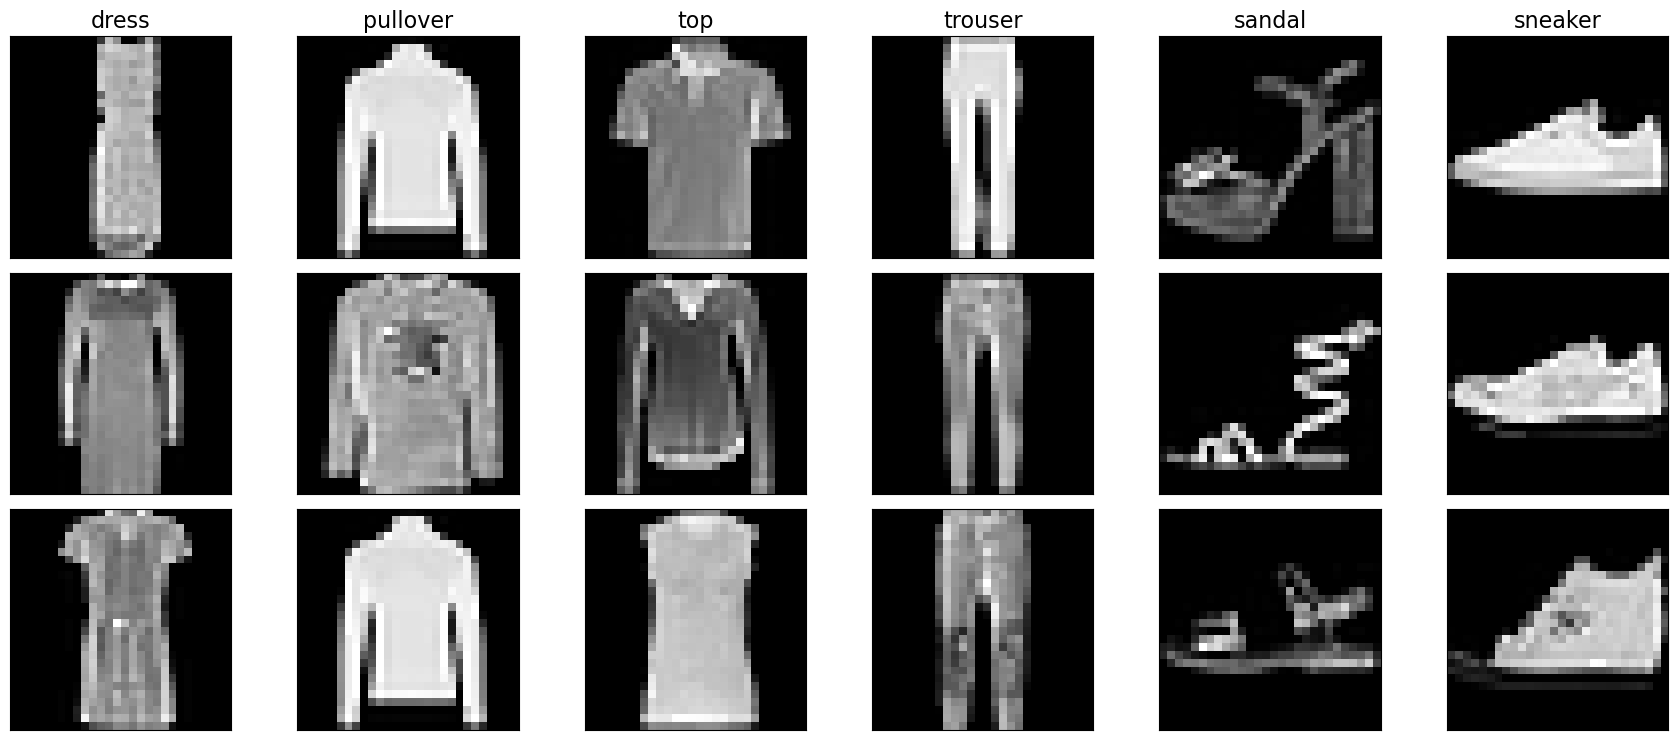

In [3]:
# prng = np.random.RandomState(0)
prng = np.random.RandomState()
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = y_va_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = x_va[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
plt.tight_layout();
plt.show();

# Data Exploration 1a

In [4]:
tr_class_dist = y_tr_df['class_name'].value_counts()
val_class_dist = y_va_df['class_name'].value_counts()

print('Training class distribution:\n' + str(tr_class_dist))
print('Validation class distribution:\n' + str(val_class_dist))


Training class distribution:
sandal      800
sneaker     800
dress       400
pullover    100
top           1
trouser       1
Name: class_name, dtype: int64
Validation class distribution:
dress       100
trouser     100
sandal      100
top         100
pullover    100
sneaker     100
Name: class_name, dtype: int64


The training data is heavily skewed with data from sandals and trainers, with only one training image for 2 classes. A challenge will be gaining a balanced weighting for each of the classes such that the dominant classes aren't always favoured by the classifier.

# Model

Run search with predefined split s.t. validation set is used for hyperparameter selection

In [5]:
# Combine training and validation datasets
x_all = np.vstack((x_tr,x_va))
y_all_df = pd.concat([y_tr_df,y_va_df])

print("Training X shape: %s\nValidation X shape: %s\nCombined X shape: %s\n" % (x_tr.shape, x_va.shape, x_all.shape))
print("Training Y shape: %s\nValidation Y shape: %s\nCombined Y shape: %s\n" % (y_tr_df.shape, y_va_df.shape, y_all_df.shape))

valid_indicators = np.hstack([
    -1 * np.ones(y_tr_df.shape[0]), # -1 means never include this example in any test split
    0  * np.ones(y_va_df.shape[0]), #  0 means include in the first test split (we count starting at 0 in python)
    ])

# Define custom splitter to use only the validation dataset for hyperparameter selection
print("Splitter dimensions: %i" % (valid_indicators.shape[0]))
my_splitter = PredefinedSplit(valid_indicators)

display(y_all_df)

Training X shape: (2102, 784)
Validation X shape: (600, 784)
Combined X shape: (2702, 784)

Training Y shape: (2102, 2)
Validation Y shape: (600, 2)
Combined Y shape: (2702, 2)

Splitter dimensions: 2702


,class_name,class_uid
0,pullover,2
1,top,0
2,dress,3
3,sandal,5
4,pullover,2
...,...,...
595,sneaker,7
596,sneaker,7
597,top,0
598,top,0


# Random search
Load previous model or run new model

In [6]:
# Older run with some unnecesary parameters.
flag = 'stop'
filename = '1B_rand_search_400.sav'

if os.path.isfile("./" + filename) and flag != 'run':
    rand_400_1b_model = pickle.load(open(filename, 'rb'))
else:
    param_dist = dict(activation=['relu', 'logistic', 'identity', 'tanh'], learning_rate_init=np.logspace(-5, 5, 100), learning_rate = ['constant','adaptive'], hidden_layer_sizes=[(10,),(20,),(50,),(100,),(200,),(500,)])

    rand_400_1b_model = sklearn.pipeline.Pipeline([
        ('rand_search', RandomizedSearchCV(sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True), param_dist, scoring='balanced_accuracy', error_score='raise', random_state=0, return_train_score=True, n_iter=400, cv= my_splitter, n_jobs = -1, refit=False))
    ])

    # Fit on x_all as the custom splitter will divide this into tr and val
    rand_400_1b_model.fit(x_all, y_all_df['class_name'])
    pickle.dump(rand_400_1b_model, open(filename, 'wb'))

In [7]:
# Removed following parameters that don't apply to lbfgs:
# batch size only for non-lbfgs. 
# Learning Rate = const, adaptive, etc... ONLY for sgd
# learning_rate_init only used for sgd or adam
# early_stopping, n_iter_no_change and validation_fraction only for sgd/adam.

flag = 'stop'
filename = '1B_rand_search_600.sav'

if os.path.isfile("./" + filename) and flag != 'run':
    rand_600_1b_model = pickle.load(open(filename, 'rb'))
else:
    rand_param_dist = dict(hidden_layer_sizes=[(10,),(20,),(50,),(100,),(200,),(500,)], activation=('identity', 'logistic', 'tanh', 'relu'), max_iter = [1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 300], alpha = np.logspace(-5,5,50))

    rand_600_1b_model = sklearn.pipeline.Pipeline([
        ('rand_search', RandomizedSearchCV(MLPClassifier(solver='lbfgs', shuffle=True, random_state=0), rand_param_dist, scoring='balanced_accuracy', error_score='raise', return_train_score=True, n_iter=600, cv= my_splitter, n_jobs = -1, refit= False, random_state=0))
    ])

    # Fit on x_all as the custom splitter will divide this into tr and val
    rand_600_1b_model.fit(x_all, y_all_df['class_name'])
    pickle.dump(rand_600_1b_model, open(filename, 'wb'))

In [8]:
randRes = rand_600_1b_model['rand_search'].cv_results_
bestIdx = rand_600_1b_model['rand_search'].best_index_ # idx 12, 16, 44 all scored the same

bestIdxs = [12,16,44]
bestParams = dict()
# bestParams[0] = {k:v[bestIdxs[0]] for k,v in randRes.items()}
# bestParams[1] = {k:v[bestIdxs[1]] for k,v in randRes.items()}
# bestParams[2] = {k:v[bestIdxs[2]] for k,v in randRes.items()}
bestParams[0] = {k:v[bestIdx] for k,v in randRes.items()}

# display(bestParams)

print(bestIdx)
print(randRes['params'][bestIdx])
print(randRes["rank_test_score"][bestIdx])
display(randRes["mean_test_score"][bestIdx])
print(bestParams[0])

264
{'max_iter': 100, 'hidden_layer_sizes': (200,), 'alpha': 1456.3484775012444, 'activation': 'relu'}
1


0.775

{'mean_fit_time': 33.003615856170654, 'std_fit_time': 0.0, 'mean_score_time': 0.04742908477783203, 'std_score_time': 0.0, 'param_max_iter': 100, 'param_hidden_layer_sizes': (200,), 'param_alpha': 1456.3484775012444, 'param_activation': 'relu', 'params': {'max_iter': 100, 'hidden_layer_sizes': (200,), 'alpha': 1456.3484775012444, 'activation': 'relu'}, 'split0_test_score': 0.775, 'mean_test_score': 0.775, 'std_test_score': 0.0, 'rank_test_score': 1, 'split0_train_score': 0.8091666666666667, 'mean_train_score': 0.8091666666666667, 'std_train_score': 0.0}


Using the custom splitter, it's saying the following:

best idx = 264
best params = {'max_iter': 100, 'hidden_layer_sizes': (200,), 'alpha': 1456.3484775012444, 'activation': 'relu'}
test score = 0.775

However when we take those parameters and make a new model and fit it to training, it performs much worse on the validation set.

In [9]:
# bestMLP1b = sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True, learning_rate_init=1e-05,learning_rate ='constant',hidden_layer_sizes=(500,),activation='identity')
# bestMLP1b.fit(x_tr,y_tr_df["class_name"])

bestMLP1b = MLPClassifier(solver='lbfgs', shuffle=True, random_state=0, max_iter=100, hidden_layer_sizes=(200,), alpha=1456.3484775012444, activation='relu')

bestMLP1b.fit(x_tr,y_tr_df["class_name"])

c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1456.3484775012444, hidden_layer_sizes=(200,), max_iter=100,
              random_state=0, solver='lbfgs')

In [10]:
tr_acc = balanced_accuracy_score(y_tr_df['class_name'], bestMLP1b.predict(x_tr))
va_acc = balanced_accuracy_score(y_va_df['class_name'], bestMLP1b.predict(x_va))
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))

Training balanced accuracy: 0.810208
Validation balanced accuracy: 0.636667


In [11]:
# Checking normal accuracy, not balanced accuracy

# # tr_acc = sklearn.metrics.accuracy_score(y_tr_df['class_name'], bestMLP1b.predict(x_tr))
# va_acc = sklearn.metrics.accuracy_score(y_va_df['class_name'], bestMLP1b.predict(x_va))
# print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))

In [12]:
pred_tr = bestMLP1b.predict(x_tr)
pred_va = bestMLP1b.predict(x_va)
pred_te = bestMLP1b.predict(x_te)

# Save output of prediction on test data to a file.
np.savetxt('yhat_test.txt', pred_te, delimiter='\n', fmt='%s')

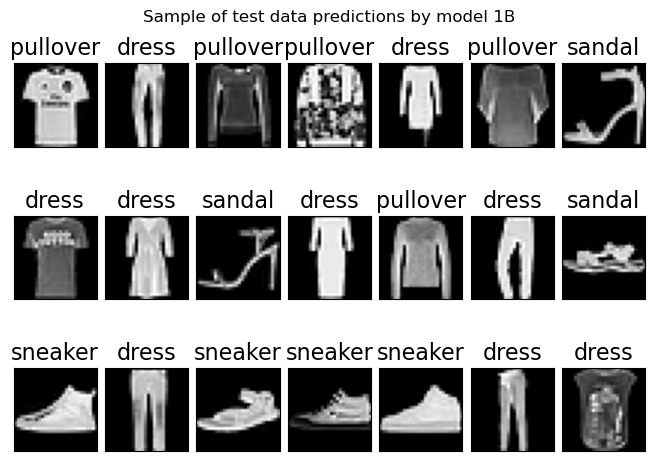

In [13]:
# Plot test data
rows = 3
cols = 7
fig, axgrid = plt.subplots(rows, cols, layout="constrained")

for imageID in range(rows*cols):
    ax = axgrid[np.unravel_index( imageID, (rows,cols))]
    x_SS = x_te[imageID].reshape((28,28))
    ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
    ax.set_xticks([]); ax.set_yticks([]);
    label = pred_te[imageID]
    ax.set_title(label, fontsize=16)
# plt.tight_layout();
fig.suptitle("Sample of test data predictions by model 1B")
plt.show();

# Grid Search

In [14]:
# Removed following parameters that don't apply to lbfgs:
# batch size only for non-lbfgs. 
# Learning Rate = const, adaptive, etc... ONLY for sgd
# learning_rate_init only used for sgd or adam
# early_stopping, n_iter_no_change and validation_fraction only for sgd/adam.

flag = 'stop'
filename = '1B_grid_search.sav'

if os.path.isfile("./" + filename) and flag != 'run':
    grid_1b_model = pickle.load(open(filename, 'rb'))
else:
    rand_param_dist = dict(hidden_layer_sizes=[(10,),(20,),(50,),(100,),(200,),(500,)], activation=('identity', 'logistic', 'tanh', 'relu'), max_iter = [1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 300], alpha = np.logspace(-5,5,50))

    grid_1b_model = sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('rand_search', GridSearchCV(MLPClassifier(solver='lbfgs', shuffle=True, random_state=0), rand_param_dist, scoring='balanced_accuracy', error_score='raise', return_train_score=True, cv= my_splitter, n_jobs = -1, refit= False))
    ])

    # Fit on x_all as the custom splitter will divide this into tr and val
    grid_1b_model.fit(x_all, y_all_df['class_name'])
    pickle.dump(grid_1b_model, open(filename, 'wb'))


In [15]:
# When refit is true we can use the best_estimator_ method, but this doesn't work with refit=false - here we need to manually run a fit on our training set.

gridRes = grid_1b_model['rand_search'].cv_results_
bestIdx = grid_1b_model['rand_search'].best_index_ 
# bestIdx = 2549 #2549 is the second best

print(gridRes['params'][bestIdx])
print(gridRes['mean_test_score'][bestIdx])

# Model with params from best index
bestMLP1bgrid =  sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('MLP', MLPClassifier(solver='lbfgs', shuffle=True, random_state=0, activation='relu', alpha=568.9866029018305, hidden_layer_sizes=(200,), max_iter=100))])
bestMLP1bgrid.fit(x_tr,y_tr_df["class_name"])

# Model with params from second best index
bestMLP1bgrid =  sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('MLP', MLPClassifier(solver='lbfgs', shuffle=True, random_state=0, activation='identity', alpha=568.9866029018305, hidden_layer_sizes=(100,), max_iter=100))])
bestMLP1bgrid.fit(x_tr,y_tr_df["class_name"])

pred_tr = bestMLP1bgrid.predict(x_tr)
pred_va = bestMLP1bgrid.predict(x_va)
pred_te = bestMLP1bgrid.predict(x_te)

tr_acc = balanced_accuracy_score(y_tr_df['class_name'], pred_tr)
va_acc = balanced_accuracy_score(y_va_df['class_name'], pred_va)
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))

print(bestIdx)
testScore = gridRes['mean_test_score']
# # # Save output of prediction on test data to a file.
# np.savetxt('yhat_test.txt', pred_te, delimiter='\n', fmt='%s')

{'activation': 'relu', 'alpha': 568.9866029018305, 'hidden_layer_sizes': (200,), 'max_iter': 100}
0.9016666666666667


c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training balanced accuracy: 0.454792
Validation balanced accuracy: 0.453333
12460


In [16]:
iters = np.arange(10,200,10)
val_bal_acc = np.zeros(iters.shape)

bestMLP1bgridIters = []
for idx in range(len(iters)):
    bestMLP1bgridIters.append(sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('MLP', MLPClassifier(solver='lbfgs', shuffle=True, random_state=0, activation='identity', alpha=568.9866029018305, hidden_layer_sizes=(100,), max_iter=iters[idx]))]))
    bestMLP1bgridIters[idx].fit(x_tr,y_tr_df["class_name"])
    val_bal_acc[idx] = balanced_accuracy_score(y_va_df['class_name'],bestMLP1bgridIters[idx].predict(x_va))

print(val_bal_acc)



c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs faile

[0.38833333 0.45833333 0.44333333 0.47       0.45833333 0.45666667
 0.45333333 0.45333333 0.45333333 0.45333333 0.45333333 0.45333333
 0.45333333 0.45333333 0.45333333 0.45333333 0.45333333 0.45333333
 0.45333333]


In [17]:
# Best classifier for 1B from grid search

bestMLPFromGrid = bestMLP1bgridIters[4]
# bestMLPFromGrid.
pred_tr = bestMLPFromGrid.predict(x_tr)
pred_va = bestMLPFromGrid.predict(x_va)
pred_te = bestMLPFromGrid.predict(x_te)

tr_acc = balanced_accuracy_score(y_tr_df['class_name'], pred_tr)
va_acc = balanced_accuracy_score(y_va_df['class_name'], pred_va)
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))

bestMLPFromGrid.get_params
# bestMLP1bgrid.
# MLPClassifier(activation='identity', alpha=568.9866029018305, max_iter=50,
#               random_state=0, solver='lbfgs')

Training balanced accuracy: 0.457292
Validation balanced accuracy: 0.458333


<bound method Pipeline.get_params of Pipeline(steps=[('scaling', MinMaxScaler()),
                ('MLP',
                 MLPClassifier(activation='identity', alpha=568.9866029018305,
                               max_iter=50, random_state=0, solver='lbfgs'))])>

Ignore for the time being - this was done with refit = true, which fits the final model from randomizedSearchCV onto the entire dataset (tr+val).

![Balanced acc of 1.0 or tr and val](best_estimator_1.png)


# Coarse Grid search as per Preetish

In [51]:
# Removed following parameters that don't apply to lbfgs:
# batch size only for non-lbfgs. 
# Learning Rate = const, adaptive, etc... ONLY for sgd
# learning_rate_init only used for sgd or adam
# early_stopping, n_iter_no_change and validation_fraction only for sgd/adam.

flag = 'stop'
filename = '1B_coarse_grid_search.sav'

if os.path.isfile("./" + filename) and flag != 'run':
    grid_1b_model = pickle.load(open(filename, 'rb'))
else:
    rand_param_dist = dict(hidden_layer_sizes=[(10,),(20,),(50,),(100,)], activation=('identity', 'relu'), max_iter = np.logspace(1,2.6,6,dtype=int), alpha = np.logspace(-5,3,9))

    grid_1b_model =   sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('grid_search', GridSearchCV(MLPClassifier(solver='lbfgs', random_state=0), rand_param_dist, scoring='balanced_accuracy', error_score='raise', return_train_score=True, cv= my_splitter, n_jobs = -1, refit= False))
    ])

    # Fit on x_all as the custom splitter will divide this into tr and val
    grid_1b_model.fit(x_all, y_all_df['class_name'])
    pickle.dump(grid_1b_model, open(filename, 'wb'))

Extract best values from grid search to make best estimator

In [52]:
# When refit is true we can use the best_estimator_ method, but this doesn't work with refit=false - here we need to manually run a fit on our training set.
gridRes = grid_1b_model['grid_search'].cv_results_
bestIdx = grid_1b_model['grid_search'].best_index_ 

testScore = gridRes['mean_test_score']

# print(testScore)
# print(gridRes['params'][bestIdx])

bestAlpha = gridRes['params'][bestIdx]['alpha']
bestLayer = gridRes['params'][bestIdx]['hidden_layer_sizes']
bestActivation = gridRes['params'][bestIdx]['activation']
bestMaxIter = gridRes['params'][bestIdx]['max_iter']

print("Grid search results:\nBest index %i with Balanced Accuracy: %f\nAlpha: %f\nLayer: %s\nActivation: %s\nMax_iter: %i" % (bestIdx,testScore[bestIdx],bestAlpha,str(bestLayer),bestActivation,bestMaxIter))

Grid search results:
Best index 285 with Balanced Accuracy: 0.736667
Alpha: 0.001000
Layer: (100,)
Activation: relu
Max_iter: 91


In [53]:
# Model with params from best index
bestMLP1bgrid =   sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('MLP', MLPClassifier(solver='lbfgs', shuffle=True, random_state=0, activation=bestActivation, alpha=bestAlpha, hidden_layer_sizes=bestLayer, max_iter=bestMaxIter))])
bestMLP1bgrid.fit(x_tr,y_tr_df["class_name"])

pred_tr = bestMLP1bgrid.predict(x_tr)
pred_va = bestMLP1bgrid.predict(x_va)
pred_te = bestMLP1bgrid.predict(x_te)

tr_acc = balanced_accuracy_score(y_tr_df['class_name'], pred_tr)
va_acc = balanced_accuracy_score(y_va_df['class_name'], pred_va)
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))


# # # Save output of prediction on test data to a file.
# np.savetxt('yhat_test.txt', pred_te, delimiter='\n', fmt='%s');

Training balanced accuracy: 1.000000
Validation balanced accuracy: 0.650000


In [92]:
#TODO Set it to use the new best parameters

### Evaluate alpha!

# Create a MLP classifier
MLP1B_EvalHype =   sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('MLP', MLPClassifier(solver='lbfgs', activation='identity', hidden_layer_sizes=(20,), max_iter=43))])
# Hyperparameters distributions - regularization strength alpha

alphaDist = np.logspace(-4,6,7)
randStateDist = range(0,16,1)
distEvalHype = dict(alpha = alphaDist, random_state=randStateDist) #[10**(-4), optParams['C'], 10**6])

#Pipeline starts!
evalHypeParamAlphaPipe = sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
    ('grid_search', GridSearchCV(MLP1B_EvalHype, distEvalHype, cv=my_splitter, verbose=0, error_score='raise', scoring='balanced_accuracy', return_train_score=True, refit= False, n_jobs = 1))
])

# TODO add random seeds and take best

evalHypeParamAlphaPipe.fit(x_all, y_all_df['class_name'])

c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs faile

Pipeline(steps=[('grid_search',
                 GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                              error_score='raise',
                              estimator=MLPClassifier(activation='identity',
                                                      hidden_layer_sizes=(20,),
                                                      max_iter=43,
                                                      solver='lbfgs'),
                              n_jobs=1,
                              param_grid={'alpha': array([1.00000000e-04, 4.64158883e-03, 2.15443469e-01, 1.00000000e+01,
       4.64158883e+02, 2.15443469e+04, 1.00000000e+06]),
                                          'random_state': range(0, 16)},
                              refit=False, return_train_score=True,
                              scoring='balanced_accuracy'))])

In [141]:
### Evaluate layersize!

# Create a MLP classifier
MLP1B_EvalHype =   sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('MLP', MLPClassifier(solver='lbfgs', activation='identity', alpha=0.012663801734674034, max_iter=43))])
# Hyperparameters distributions - regularization strength alpha

layerDist = [(1,),(6,),(8,),(10,),(12,),(15,),(20,),(24,),(30,),(40,),(50,),(75,),(100,)]

randStateDist = range(0,16,1)
distEvalHype = dict(hidden_layer_sizes = layerDist, random_state=randStateDist)

#Pipeline starts!
evalHypeParamLayerPipe =  sklearn.pipeline.Pipeline([
    ('scaling', MinMaxScaler()),
    ('grid_search', GridSearchCV(MLP1B_EvalHype, distEvalHype, cv=my_splitter, verbose=0, error_score='raise', scoring='balanced_accuracy', return_train_score=True, refit= False, n_jobs = -1))
])

# TODO rerun with njobs = 1

evalHypeParamLayerPipe.fit(x_all, y_all_df['class_name'])

Pipeline(steps=[('grid_search',
                 GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                              error_score='raise',
                              estimator=MLPClassifier(activation='identity',
                                                      alpha=0.012663801734674034,
                                                      max_iter=43,
                                                      solver='lbfgs'),
                              n_jobs=-1,
                              param_grid={'hidden_layer_sizes': [(1,), (6,),
                                                                 (8,), (10,),
                                                                 (12,), (15,),
                                                                 (20,), (24,),
                                                                 (30,), (40,),
                                                                 (50,), (75,),
                                                                 (100,)],
                                          'random_state': range(0, 16)},
                              refit=False, return_train_score=True,
                              scoring='balanced_accuracy'))])

In [131]:
layerDistUnpack = [e for e, in layerDist]
layerDisRep = np.repeat(layerDistUnpack,16)


[ 10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  18  18  18  18
  18  18  18  18  18  18  18  18  18  18  18  18  19  19  19  19  19  19
  19  19  19  19  19  19  19  19  19  19  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  21  21  21  21  21  21  21  21  21  21
  21  21  21  21  21  21  22  22  22  22  22  22  22  22  22  22  22  22
  22  22  22  22  23  23  23  23  23  23  23  23  23  23  23  23  23  23
  23  23  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24
  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  30  30
  30  30  30  30  30  30  30  30  30  30  30  30  30  30  40  40  40  40
  40  40  40  40  40  40  40  40  40  40  40  40  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 125 125 125 125 125 125 12

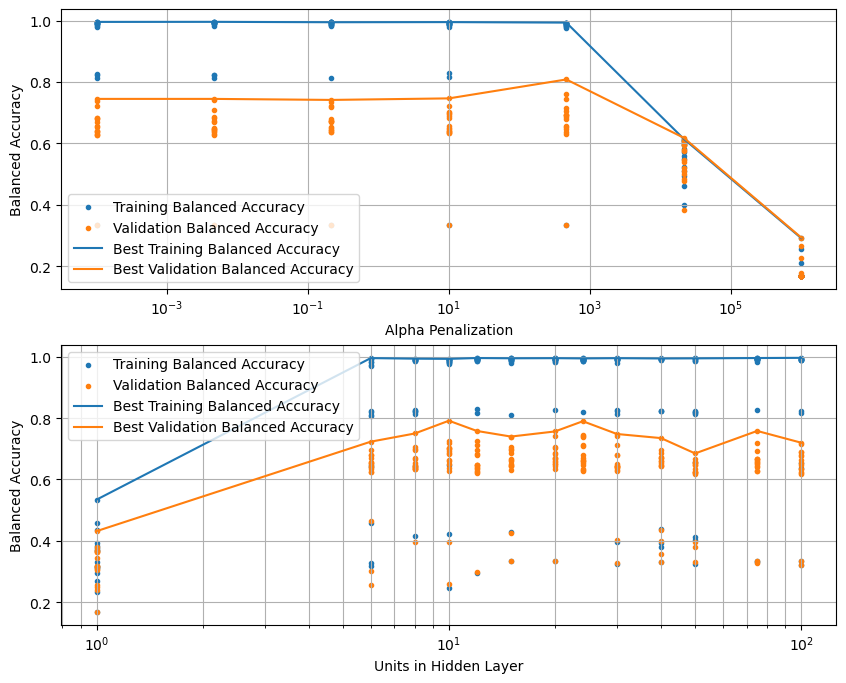

In [142]:
# Extract Alpha data for plotting
alphaRes = evalHypeParamAlphaPipe['grid_search'].cv_results_
# reshape to rows of one alpha, with columns of different random seeds
alphaScoreTrainReshape = alphaRes['mean_train_score'].reshape((len(alphaDist),16))
alphaScoreValReshape = alphaRes['mean_test_score'].reshape((len(alphaDist),16))

# Select best runs for each alpha
alpha_Train = np.max(alphaScoreTrainReshape,axis=1)
alpha_Val = np.max(alphaScoreValReshape,axis=1)
# Make second alphaDist to be used for scatter plot (i.e. values repeated for each rand state)
alphaDistRep = alphaRes['param_alpha']

# Extract layer data for plotting
layerRes = evalHypeParamLayerPipe['grid_search'].cv_results_
# reshape to rows of one layer size, with columns of different random seeds
layerScoreTrainReshape = layerRes['mean_train_score'].reshape((len(layerDist),16))
layerScoreValReshape = layerRes['mean_test_score'].reshape((len(layerDist),16))

# Select best runs for each layer size
layer_Train = np.max(layerScoreTrainReshape,axis=1)
layer_Val = np.max(layerScoreValReshape,axis=1)
# Make second layerDist to be used for scatter plot (i.e. values repeated for each rand state)
layerDistUnpack = [e for e, in layerDist]
layerDistRep = np.repeat(layerDistUnpack,16)

# # Extract max_iter data for plotting
# IterVars = evalHypeParamIterPipe['cross validation'].cv_results_

# Iter_Train = IterVars['mean_train_score']
# Iter_Val = IterVars['mean_test_score']
# Iter_TrainFolds = np.vstack((IterVars['split0_train_score'], IterVars['split1_train_score'], IterVars['split2_train_score'], IterVars['split3_train_score'], IterVars['split4_train_score']))
# Iter_ValFolds = np.vstack((IterVars['split0_test_score'], IterVars['split1_test_score'], IterVars['split2_test_score'], IterVars['split3_test_score'], IterVars['split4_test_score']))
# IterDistFolds = np.tile(maxIterDist, (numFolds,1))

# Plot accuracy vs C and max_iter hyperparameters

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
ax1.scatter(alphaDistRep, alphaRes['mean_train_score'], label='Training Balanced Accuracy',marker='.')
ax1.scatter(alphaDistRep, alphaRes['mean_test_score'], label='Validation Balanced Accuracy',marker='.')
ax1.plot(alphaDist, alpha_Train, label='Best Training Balanced Accuracy')
ax1.plot(alphaDist, alpha_Val, label='Best Validation Balanced Accuracy')
ax1.legend()
ax1.set_xlabel('Alpha Penalization')
ax1.set_ylabel('Balanced Accuracy')
ax1.set_xscale('log')
ax1.grid(which='both')

ax2.scatter(layerDistRep, layerRes['mean_train_score'], label='Training Balanced Accuracy',marker='.')
ax2.scatter(layerDistRep, layerRes['mean_test_score'], label='Validation Balanced Accuracy',marker='.')
ax2.plot(layerDistUnpack, layer_Train, label='Best Training Balanced Accuracy')
ax2.plot(layerDistUnpack, layer_Val, label='Best Validation Balanced Accuracy')
ax2.legend()
ax2.set_xlabel('Units in Hidden Layer')
ax2.set_ylabel('Balanced Accuracy')
ax2.set_xscale('log')
ax2.grid(which='both')

# Repeat with data normalized

In [40]:
# normalize data - necessary
x_tr_norm = x_tr /255
x_va_norm = x_va /255


In [41]:
# Combine training and validation datasets
x_all_norm = np.vstack((x_tr_norm,x_va_norm))
y_all_df = pd.concat([y_tr_df,y_va_df])

print("Training X shape: %s\nValidation X shape: %s\nCombined X shape: %s\n" % (x_tr_norm.shape, x_va_norm.shape, x_all_norm.shape))
print("Training Y shape: %s\nValidation Y shape: %s\nCombined Y shape: %s\n" % (y_tr_df.shape, y_va_df.shape, y_all_df.shape))

valid_indicators = np.hstack([
    -1 * np.ones(y_tr_df.shape[0]), # -1 means never include this example in any test split
    0  * np.ones(y_va_df.shape[0]), #  0 means include in the first test split (we count starting at 0 in python)
    ])

# Define custom splitter to use only the validation dataset for hyperparameter selection
print("Splitter dimensions: %i" % (valid_indicators.shape[0]))
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators)


Training X shape: (2102, 784)
Validation X shape: (600, 784)
Combined X shape: (2702, 784)

Training Y shape: (2102, 2)
Validation Y shape: (600, 2)
Combined Y shape: (2702, 2)

Splitter dimensions: 2702


In [42]:
flag = 'stop'
filename = '1Bnorm_rand_search_100.sav'

if os.path.isfile("./" + filename) and flag != 'run':
    fashion_pipes_norm = pickle.load(open(filename, 'rb'))
else:
    param_dist = dict(activation=['relu', 'logistic', 'identity', 'tanh'], learning_rate_init=np.logspace(-5, 5, 100), learning_rate = ['constant','adaptive'], hidden_layer_sizes=[(20,),(50,),(100,),(200,),(500,)])

    fashion_pipes_norm = sklearn.pipeline.Pipeline([
        ('rand_search', RandomizedSearchCV(sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True), param_dist, scoring='balanced_accuracy', error_score='raise', random_state=0, return_train_score=True, n_iter=100, cv= my_splitter, n_jobs = -1, refit=False))
    ])

    fashion_pipes_norm.fit(x_all_norm, y_all_df['class_name'])
    pickle.dump(fashion_pipes, open(filename, 'wb'))

In [43]:
filename = '1D_initial_RanSearch.sav'
print("./" + filename)

os.path.isfile("./" + filename)

./1D_initial_RanSearch.sav


False

In [44]:
# Assess the same procedure with normalized input data - same results and same accuracy found in this case.display

gridRes = fashion_pipes['rand_search'].cv_results_

display(gridRes)
bestIdxNorm = fashion_pipes['rand_search'].best_index_ # idx 12, 16, 44 all scored the same

bestIdxs = [12,16,44]
bestParams = dict()
bestParams[0] = {k:v[bestIdxs[0]] for k,v in gridRes.items()}
bestParams[1] = {k:v[bestIdxs[1]] for k,v in gridRes.items()}
bestParams[2] = {k:v[bestIdxs[2]] for k,v in gridRes.items()}

display(bestParams)
# print(gridRes["mean_test_score"])
# display(gridRes["mean_test_score"])

NameError: name 'fashion_pipes' is not defined

In [ ]:
bestMLP1bNorm = sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True, learning_rate_init=1e-05,learning_rate ='constant',hidden_layer_sizes=(500,),activation='identity')
bestMLP1bNorm.fit(x_tr_norm,y_tr_df["class_name"])

In [ ]:
tr_acc = balanced_accuracy_score(y_tr_df['class_name'], bestMLP1bNorm.predict(x_tr_norm))
va_acc = balanced_accuracy_score(y_va_df['class_name'], bestMLP1bNorm.predict(x_va_norm))
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))

For some reason the validation accuracy seems to be lower on normalized data